In [37]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import talib
import csv
from statistics import mean

In [49]:
symbols = []
def getSymbolsCSV(fileName):
    
    global symbols
    print('\nLoading data from ' + fileName)

    with open(fileName) as csvfile:
    
        readCSV = csv.reader(csvfile, delimiter=',')
        
        for row in readCSV:
            
            symbol  = str(row[0]).replace('ï»¿', '')
            
            symbols.append(symbol) 
           
            
getSymbolsCSV('C:\\Users\\faiza\\Automated-Fundamental-Analysis\\SymbolData\\S&P500Symbols.csv')


Loading data from C:\Users\faiza\Automated-Fundamental-Analysis\SymbolData\S&P500Symbols.csv


In [ ]:
symbols

In [76]:
def calculateStrategyReturns(ticker, startDate, endDate):

    data = yf.download(tickers=ticker, start=startDate, end=endDate)

    data = data.dropna()

    data['SAR'] = talib.SAR(data.High, data.Low, acceleration=0.02, maximum=0.2)

    # Calculate Tenkan-sen
    high_9 = data.High.rolling(9).max()
    low_9 = data.Low.rolling(9).min()
    data['tenkan_sen_line'] = (high_9 + low_9) /2

    # Calculate Kijun-sen
    high_26 = data.High.rolling(26).max()
    low_26 = data.Low.rolling(26).min()
    data['kijun_sen_line'] = (high_26 + low_26) / 2

    # Calculate Senkou Span A
    data['senkou_spna_A'] = ((data.tenkan_sen_line + data.kijun_sen_line) / 2).shift(26)

    # Calculate Senkou Span B
    high_52 = data.High.rolling(52).max()
    low_52 = data.High.rolling(52).min()
    data['senkou_spna_B'] = ((high_52 + low_52) / 2).shift(26)

    # Calculate Chikou Span B
    data['chikou_span'] = data.Close.shift(-26)

    # Plot closing price and parabolic SAR
    #komu_cloud = data[['Close','SAR']][:500].plot(figsize=(12, 7))

    # Plot Komu cloud
    komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
     where=data.senkou_spna_A[:500] >= data.senkou_spna_B[:500], color='lightgreen')

    komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
     where=data.senkou_spna_A[:500] < data.senkou_spna_B[:500], color='lightcoral')



    data['signal'] = 0

    
    # Buy Signal 
    #data.loc[(data.Close > data.senkou_spna_A) & (data.Close >data.senkou_spna_B) & (data.Close > data.SAR), 'signal'] = 1
    data.loc[(data.Close > data.SAR), 'signal'] = 1
    
    # Sell Signal
    #data.loc[(data.Close < data.senkou_spna_A) & (data.Close < data.senkou_spna_B) & (data.Close < data.SAR), 'signal'] = -1
    data.loc[(data.Close < data.SAR), 'signal'] = -1

    
    # Calculate daily returns
    daily_returns = data.Close.pct_change()
    # Calculate strategy returns
    strategy_returns = daily_returns *data['signal'].shift(1)


    dates = []
    returns = []
    avgGains = []

    buyPoint = 0
    startingCapital = 5000
    cash = startingCapital

    sharesHeld = 0
    amountInStocks = 0

    prevSignal = 0

    for row in data.iterrows():

        signal = row[-1][-1]
        close = float(row[1][4])

        if signal == 1 and (prevSignal == 0 or prevSignal == -1): 

            sharesHeld = cash // close
            amountHeld = close * sharesHeld
            cash = cash - amountHeld

            buyPoint = close

            #print('BUY', str(row[0])[0 : 10], '(' + str(close) + ')', sharesHeld, close * sharesHeld, cash)
            #print()

            prevSignal = 1

        if signal == -1 and prevSignal == 1:

            cash += sharesHeld * close

            avgGains.append((close - buyPoint) / buyPoint * 100)

            #print('SELL', str(row[0])[0 : 10], '(' + str(close) + ')', sharesHeld, sharesHeld * close, cash)
            #print()

            sharesHeld = 0
            prevSignal = 0
            buyPoint = 0



        returns.append((sharesHeld * close) + cash)
        dates.append(row[0])
    
    
    plt.plot(returns)
    
    print()
    print(ticker)
    
    avgGain = mean(avgGains)
    
    print('Avg Gain', round(avgGain, 2))

    posCount = len(list(filter(lambda x: (x >= 0), avgGains)))
    negCount = len(list(filter(lambda x: (x < 0), avgGains))) 
    
    print('Positive Trades: {0}  Negative Trades: {1}'.format(posCount, negCount))
    
    print('\nAvg Positive Trade:', round(mean(list(filter(lambda x: (x > 0), avgGains))), 2))
    print('Avg Negative Trade:', round(mean(list(filter(lambda x: (x < 0), avgGains))), 2))

    stockReturn = (data['Adj Close'][-1] - data['Adj Close'][0]) / data['Adj Close'][0] * 100
    stratReturn = (returns[-1] - startingCapital) / startingCapital * 100

    print('\nStrategy Return: {0}  Stock Return: {1}'.format(round(stratReturn, 2), round(stockReturn, 2)))
    
    return ((abs(stratReturn) - abs(stockReturn)) * ((posCount / negCount) * 10) * avgGain) / 100

[*********************100%***********************]  1 of 1 downloaded

AAL
Avg Gain -3.77
Positive Trades: 5  Negative Trades: 10

Avg Positive Trade: 15.64
Avg Negative Trade: -13.47

Strategy Return: -55.93  Stock Return: -22.71
[*********************100%***********************]  1 of 1 downloaded

AAPL
Avg Gain 2.33
Positive Trades: 10  Negative Trades: 6

Avg Positive Trade: 6.06
Avg Negative Trade: -3.89

Strategy Return: 40.37  Stock Return: 71.74
[*********************100%***********************]  1 of 1 downloaded

ABC
Avg Gain -1.43
Positive Trades: 5  Negative Trades: 11

Avg Positive Trade: 4.25
Avg Negative Trade: -4.01

Strategy Return: -22.17  Stock Return: 40.49
[*********************100%***********************]  1 of 1 downloaded

ABT
Avg Gain 1.43
Positive Trades: 9  Negative Trades: 9

Avg Positive Trade: 6.34
Avg Negative Trade: -3.48

Strategy Return: 23.03  Stock Return: 39.27
[*********************100%***********************]  1 of 1 downloaded

ADBE
Avg Gain 3.71

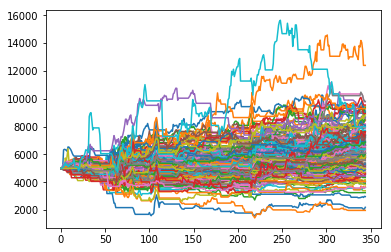

In [77]:

stratReturns = []

for symbol in symbols:
    stratReturns.append([symbol, calculateStrategyReturns(symbol, '2020-01-02', '2021-05-15')])

In [78]:
sorted(stratReturns,key=lambda l:l[1], reverse=True)

[['CZR', 71.75672656830764],
 ['DD', 56.2508912965512],
 ['BLK', 51.61892104858335],
 ['DRI', 50.10552845365893],
 ['CVX', 40.82060927780949],
 ['DISCA', 33.86350391492167],
 ['APA', 31.76517053762833],
 ['AKAM', 31.639697373867133],
 ['ALL', 31.06939633245577],
 ['APD', 28.06137363641832],
 ['CINF', 26.80649454739213],
 ['DISH', 23.34084001575078],
 ['C', 21.932417110641058],
 ['CRM', 21.582959730341308],
 ['DISCK', 21.03036790014382],
 ['BKR', 17.00607512505495],
 ['CMG', 15.578605700303726],
 ['DOV', 14.341834200962744],
 ['CTSH', 13.875074174827862],
 ['DUK', 13.01333312184348],
 ['EOG', 12.321575122221887],
 ['ADBE', 11.503846534417619],
 ['ADSK', 11.169377667406161],
 ['BRK-B', 10.585725616312457],
 ['DXCM', 10.509860879910466],
 ['ABBV', 9.24034587279474],
 ['AME', 8.828650724973823],
 ['DVN', 8.436655294577854],
 ['ARE', 7.789228718447937],
 ['AIZ', 6.109382418231439],
 ['ALLE', 5.891801193289309],
 ['COP', 5.607581184370734],
 ['CBOE', 5.324187779836443],
 ['CE', 4.86864961718